In [12]:
import os
import bson
import gzip
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, misc

from GF_data_tools.fetch_data import run_query
from GF_data_tools.wave_utils.new_wave import TimeWave

In [13]:
AURORA_MOUNT = os.getenv('AURORA_MOUNT')
EXPERIMENT = 'pi3b'
MANIFEST = '2022_08_18'
CURRENT_LAYER = 'rogowski_combined/gapless'
VOLTAGE_LAYER = 'electrode_voltage/formation/scaled'

In [14]:
def plot_shot_current_and_voltage(shot : int):
    v_result = run_query({'manifest': MANIFEST,
                        'experiment': EXPERIMENT,
                        'shot': shot,
                        'layers': VOLTAGE_LAYER,
                        'nodisplay': True})
    v_wave = v_result['waves'][0]
    plt.figure(figsize = (10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(v_wave.x_axis(), v_wave)
    plt.ylabel(v_wave.units)
    plt.title(shot)

    i_result = run_query({'manifest': MANIFEST,
                        'experiment': EXPERIMENT,
                        'shot': shot,
                        'layers': CURRENT_LAYER,
                        'nodisplay': True})
    i_wave = i_result['waves'][0]
    plt.subplot(1, 2, 2)
    plt.plot(i_wave.x_axis(), i_wave / 1000)
    plt.ylabel('k' + i_wave.units)

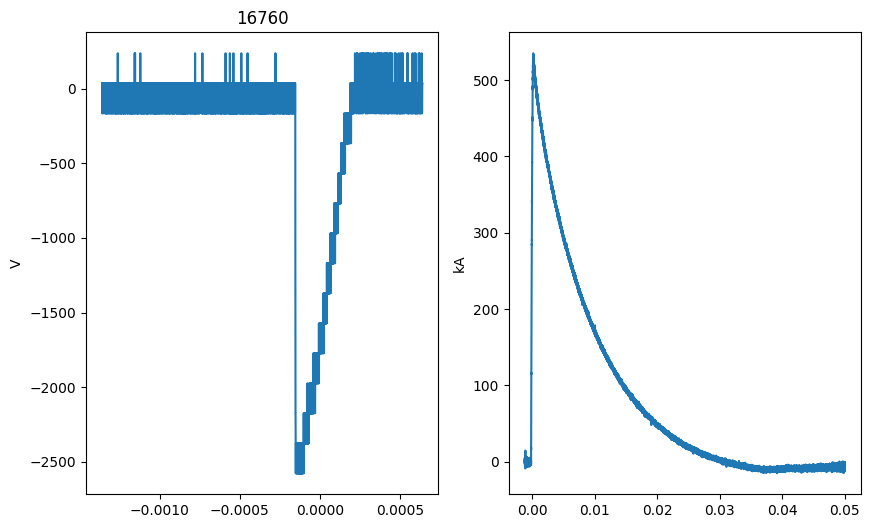

In [15]:
plot_shot_current_and_voltage(16760)

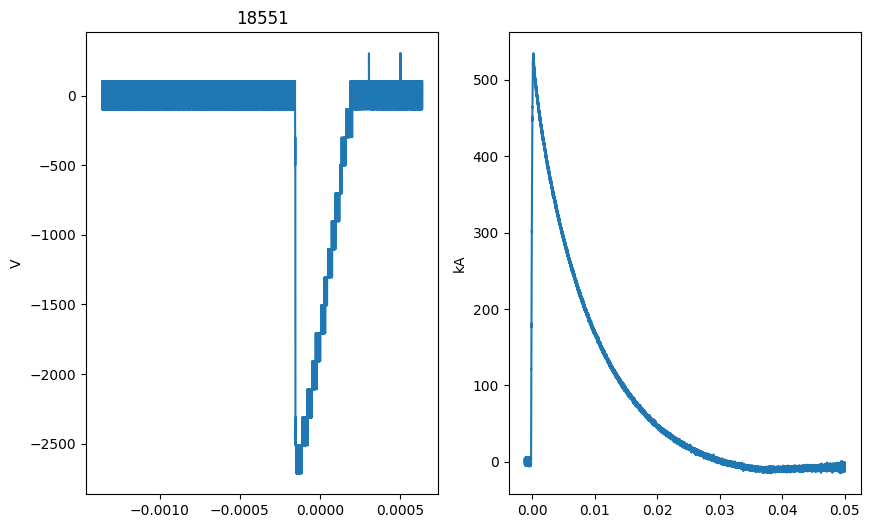

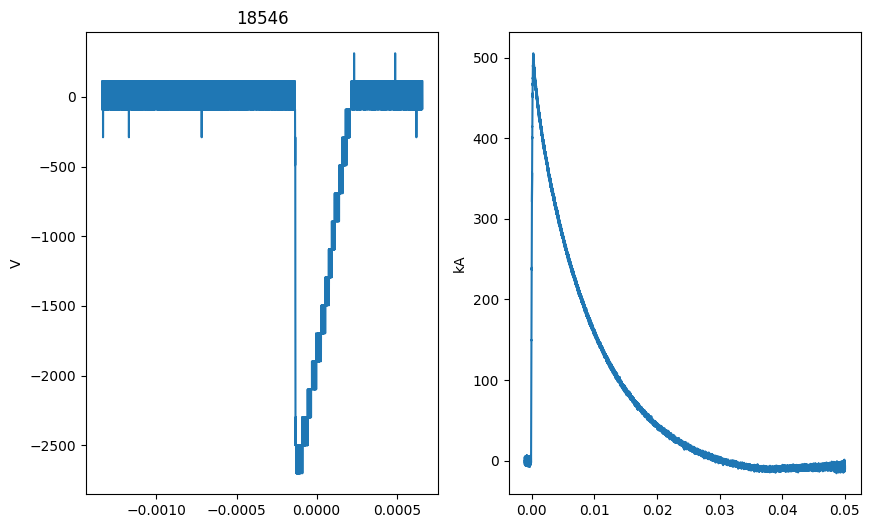

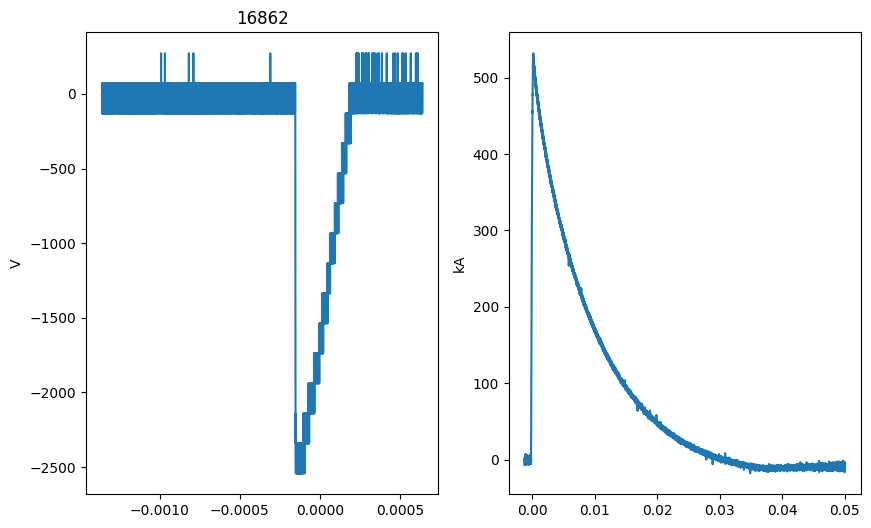

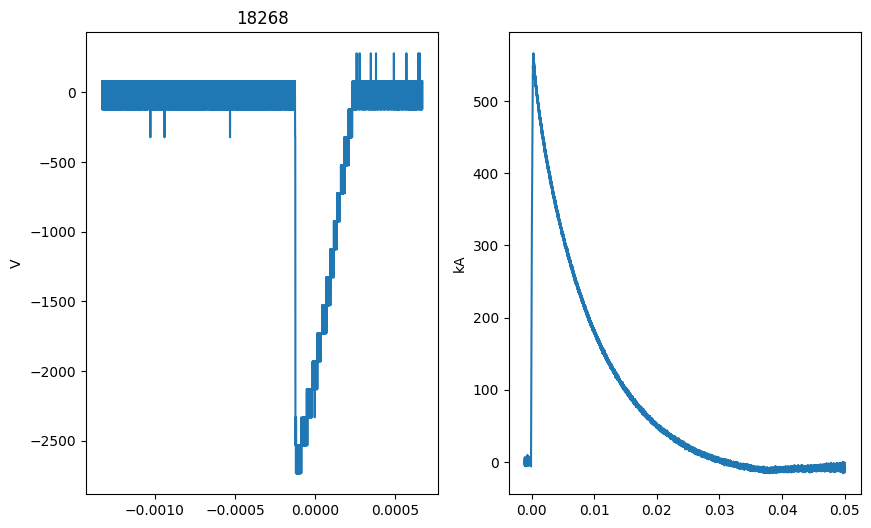

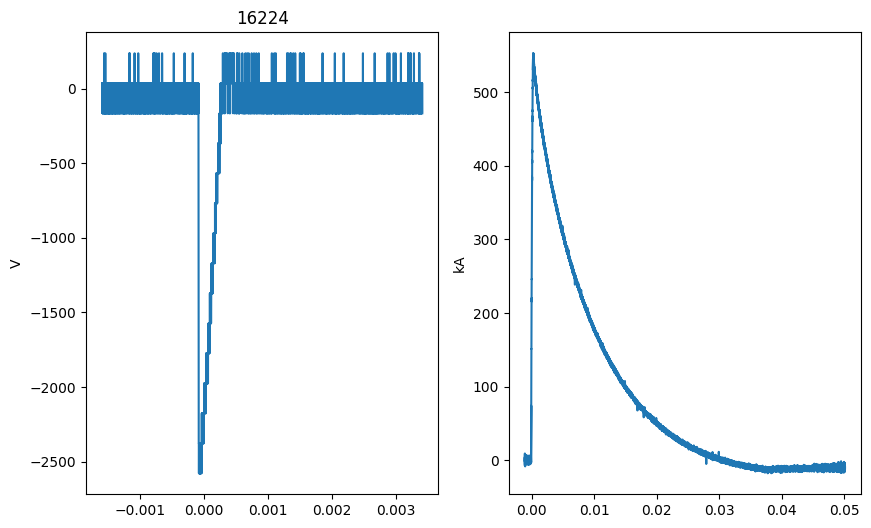

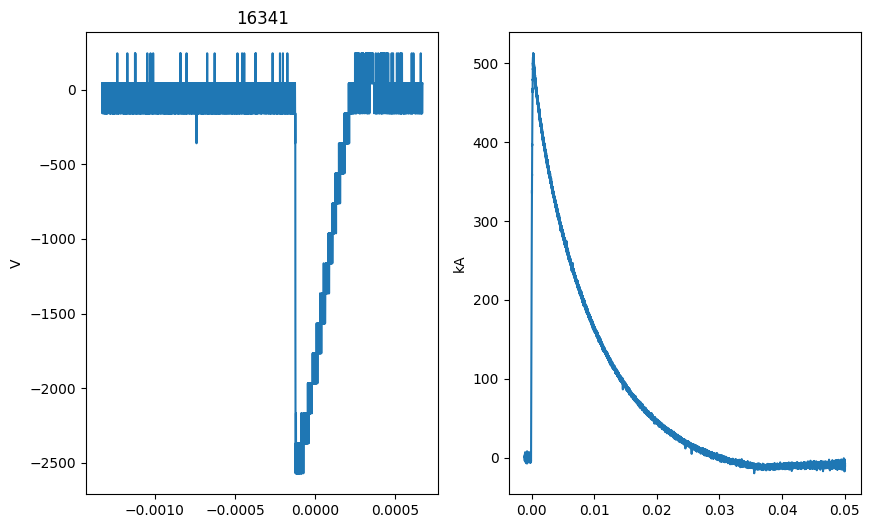

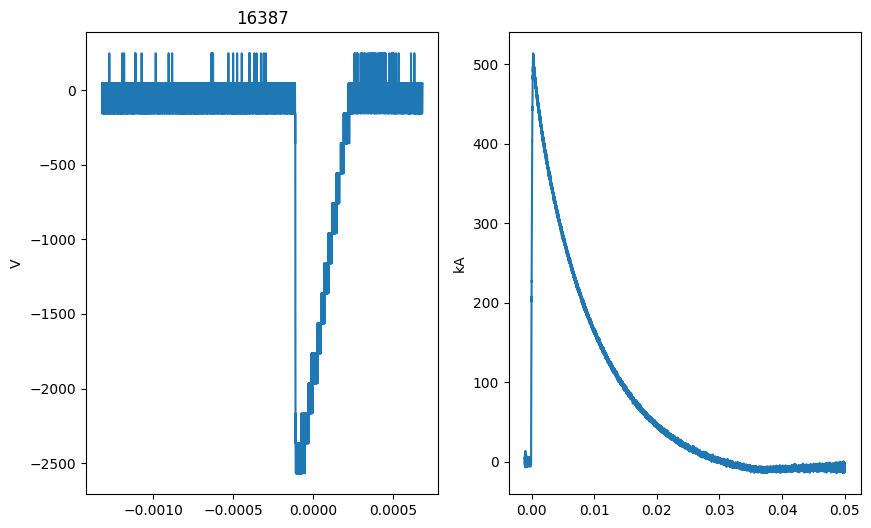

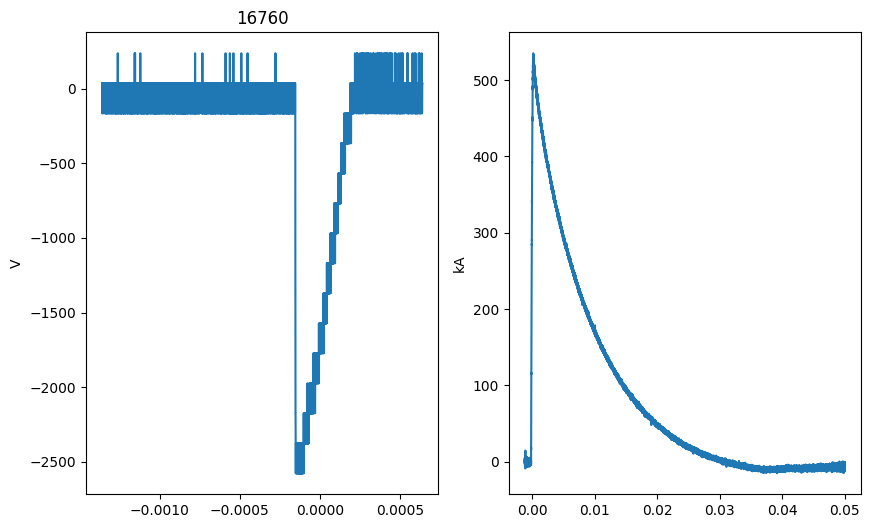

In [16]:
no_plasma_shots = [18551, 18546, 16862, 18268, 16224, 16341, 16387, 16760]

for no_plasma_shot in no_plasma_shots:
    plot_shot_current_and_voltage(no_plasma_shot)


In [17]:
def plot_wave_at_layer(shot : int, layer : str):
    result = run_query({'manifest': MANIFEST,
                        'experiment': EXPERIMENT,
                        'shot': shot,
                        'layers': layer,
                        'nodisplay': True})
    wave = result['waves'][0]
    plt.plot(wave.x_axis(), wave)
    plt.ylabel(wave.units)
    plt.title(shot)

In [18]:
plot_wave_at_layer(18456, )

TypeError: plot_wave_at_layer() missing 1 required positional argument: 'layer'

In [20]:
def get_interpolated_wave_function(shot : int, layer_name : str):
    result = run_query({'manifest': MANIFEST,
                        'experiment': EXPERIMENT,
                        'shot': shot,
                        'layers': layer_name,
                        'nodisplay': True})
    wave = result['waves'][0]
    if 'voltage' in layer_name:
        voltage_xs = wave.x_axis().tolist()
        voltage_xs.append(.05006)
        voltage_ys = wave.tolist()
        voltage_ys.append(0)
        return interpolate.interp1d(voltage_xs, voltage_ys)
    else:
        return interpolate.interp1d(wave.x_axis(), wave)

In [21]:
no_plasma_shots = [18546, 18551, 18451]
Is = [get_interpolated_wave_function(shot, CURRENT_LAYER) for shot in no_plasma_shots]
Vs = [get_interpolated_wave_function(shot, VOLTAGE_LAYER) for shot in no_plasma_shots]

In [22]:
def current_dot_f(current_f, t):
    return misc.derivative(current_f, t, dx=1e-3)

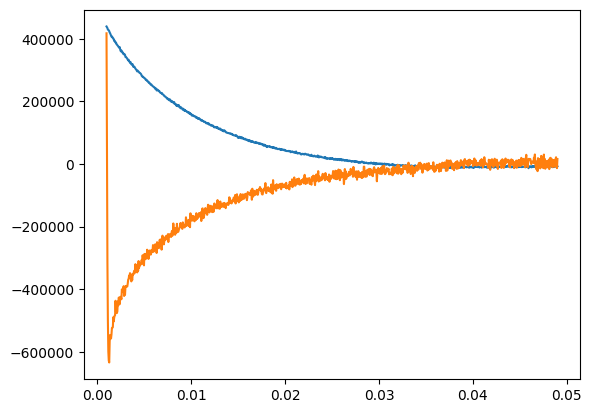

In [23]:
ts = np.linspace(0.001, .049, 1000).tolist()
I_f = Is[0]
I_dot_f = lambda t : current_dot_f(Is[0], t)

I_vals = [I_f(t) for t in ts]
I_dot_vals = [I_dot_f(t) * 1e-2 for t in ts]

plt.plot(ts, I_vals)
plt.plot(ts, I_dot_vals) # maybe I_dot is messed up
plt.show()

$$\dot{\phi_{total}} = \dot{L}I + L\dot{I} = -(V - IR) \implies$$
$$\frac{L_0}{\tau}e^{\frac{-t}{\tau}}I(t) + (L_f  - L_0e^{\frac{-t}{\tau}})\dot{I}(t) = -V(t) + I(t)(R_f + R_0e^{\frac{-t}{\tau}})$$

In [24]:
import numpy
import math
from scipy.optimize import leastsq

def to_fit(ts : list, I, V, I_dot, L_0, L_f, R_0, R_f, tau):
  return [(L_0 / tau)*math.exp(-t/tau)*I(t) + (L_f - L_0*math.exp(-t/tau))*I_dot(t) + V(t) - I(t)*(R_f + R_0*math.exp(-t/tau)) for t in ts]

def leastsq_func(params, *args):
  t=args[0] # Size 1xn where n = # t values
  Is=args[1] # Size m*n where m is number of curves
  Vs=args[2] # m*n
  
  num_curves = len(Is)
  num_ts = len(t)

  L_0, L_f, R_0, R_f, tau = params

  yfit=numpy.empty(num_curves * num_ts)
  for curve_index in range(num_curves):
    start = curve_index * num_ts
    end = start + num_ts

    if L_0 <= 0 or L_f <= 0 or R_0 <= 0 or R_f <= 0 or tau <= 0:
      yfit[start:end] = [1e12]*num_ts # make sure can only be positive
    # elif L_f < L_0:
    #     yfit[start:end] = [1e9]*num_ts # otherwise will have negative inductance for initial times
    else:
      I_dot = lambda t : current_dot_f(Is[curve_index], t)
      yfit[start:end] = to_fit(t, Is[curve_index], Vs[curve_index], I_dot, L_0, L_f, R_0, R_f, tau) # trying ot minimize this 

  return yfit

In [34]:
ts = np.linspace(0.001, .049, 500)

# params = [1e-2, 1e-2, 1e-2, 1e-2, 1e-3] # [8.99815601e-03 7.01967411e-03 3.05580962e+00 1.79716294e-09 1.35646624e-03]
params = [1e-6, 1e-6, 1e-6, 1e-6, 1e-3] # [7.88438055e-07, 1.94215761e-07, 9.60828781e-06, 3.50240761e-04, 9.99999984e-04]

args = tuple([ts, Is, Vs])

result = leastsq(leastsq_func, params, args=args, ftol=1e-8, xtol = 1e-10, maxfev=2000)
print(result[0])
L_0, L_f, R_0, R_f, tau = result[0]

[9.85719527e-07 9.93786975e-07 1.50799844e-05 7.91564535e-12
 9.92063130e-04]


In [9]:
def L(L_0, L_f, tau, t):
    return L_f - L_0*math.exp(-t/tau)

def R(R_0, R_f, tau, t):
    return R_f + R_0*math.exp(-t/tau)

Text(0.5, 1.0, 'R')

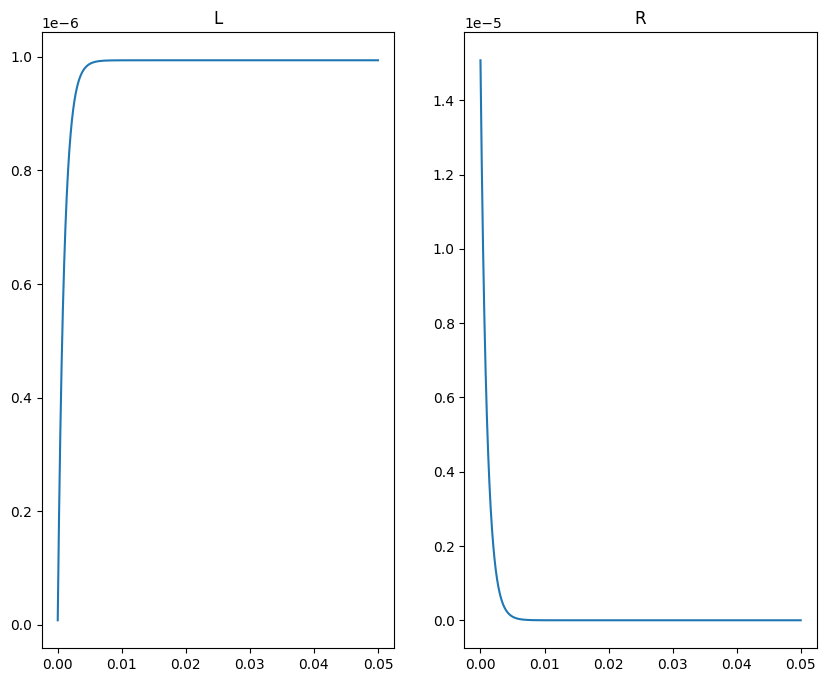

In [26]:
ts = np.linspace(0,.05, 1000)

plt.figure(figsize=(10, 8))
Rs = [R(R_0, R_f, tau, t) for t in ts]
Ls = [L(L_0, L_f, tau, t) for t in ts]

plt.subplot(1, 2, 1)
plt.plot(ts, Ls)
plt.title('L')
plt.subplot(1, 2, 2)
plt.plot(ts, Rs)
plt.title('R')

$$\phi_{wall} = LI$$

In [35]:
def get_phi_wall(shot : int, L_fxn):
    current_f = get_interpolated_wave_function(shot, CURRENT_LAYER)
    return lambda t : current_f(t) * L_fxn(t)

In [38]:
L_fxn = lambda t : L(L_0, L_f, tau, t)
phi_wall_fxn = get_phi_wall(18456, L_fxn)

In [40]:
type(L_fxn * L_fxn)

TypeError: unsupported operand type(s) for *: 'function' and 'function'

$$\phi_{total} = -\int{(V - IR)dt }$$

In [41]:
from scipy import integrate

def get_phi_total(shot : int, R_fxn, bound : float, bound_upper : bool):
    current_fxn = get_interpolated_wave_function(shot, CURRENT_LAYER)
    voltage_fxn = get_interpolated_wave_function(shot, VOLTAGE_LAYER)
    integrand_fxn = lambda t : voltage_fxn(t) - current_fxn(t) * R_fxn(t)
    if bound_upper:
        return lambda t : -1*integrate.quad(integrand_fxn, t, bound)
    else:
        return lambda t : -1*integrate.quad(integrand_fxn, bound, t)

In [44]:
R_fxn = lambda t : R(R_0, R_f, tau, t)
phi_total_lower_bound_fxn = get_phi_total(18456, R_fxn, .001, False)

In [45]:
phi_total_lower_bound_fxn(.02)

/home/brendan.posehn@gf.local/ramdisk/ipykernel_130341/483189426.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return lambda t : -1*integrate.quad(integrand_fxn, bound, t)


()

In [47]:
def get_i_fxn():
    f = lambda x : x**2
    return lambda x : integrate.quad(f, 0, x)

i_fxn = get_i_fxn()
i_fxn(2)


(2.666666666666667, 2.960594732333751e-14)

$$\phi_{plasma} = \phi_{total} - \phi_{wall}$$